In [33]:
!pwd

/panda/eedy/iono-notebook


In [34]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import h5py
import numpy as np
import os
import datetime as dt
import numpy as np
import math
from scipy import interpolate
from mintpy.objects import ionex, timeseries
from mintpy.simulation import iono
from mintpy.utils import readfile, writefile
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm
from mintpy import iono_tec
from mintpy.cli import diff, ifgram_inversion, modify_network, reference_point, reference_date
from mintpy.utils import utils as ut
from tqdm import trange
import h5py

from datetime import datetime
from netCDF4 import Dataset
from mintpy.utils import ptime, readfile, writefile


In [35]:
tframe_left = gpd.read_file("/home/eedy/data/aux/tframe_orbit/tframe_left_look.gpkg")
tframe_left.crs = "EPSG:4326"
# 初始化列表
ascending_frame_time_date = []
ascending_frame_time_utc_sec = []
ascending_NearLookAngle = []
ascending_FarLookAngle = []
ascending_lat1 = []
ascending_lon1 = []
ascending_lat2 = []
ascending_lon2 = []
ascending_lat3 = []
ascending_lon3 = []
ascending_lat4 = []
ascending_lon4 = []

descending_frame_time_date = []
descending_frame_time_utc_sec = []
descending_latitude = []
descending_longitude = []
descending_NearLookAngle = []
descending_FarLookAngle = []
descending_lat1 = []
descending_lon1 = []
descending_lat2 = []
descending_lon2 = []
descending_lat3 = []
descending_lon3 = []
descending_lat4 = []
descending_lon4 = []

# 遍历 track_frame
for index, row in tframe_left.iterrows():
    # 获取日期和时间
    startET = row['startET']
    endET = row['endET']
    tcenter = (startET + endET)/2.0
    import datetime
    frame_time_utc = datetime.datetime(2000,1,1)+datetime.timedelta(seconds=tcenter)
    frame_time_date = frame_time_utc.date()
    frame_time_utc_sec = frame_time_utc.hour * 60 + frame_time_utc.minute + frame_time_utc.second / 60

    # 获取入射角
    swathNearLookAngle = row['swathNearLookAngle']
    swathFarLookAngle = row['swathFarLookAngle']

    polygon = row['geometry']
    exterior_coords = polygon.geoms[0].exterior.coords
    # 提取四个角点
    corners = [exterior_coords[0], exterior_coords[len(exterior_coords) // 4],exterior_coords[len(exterior_coords) // 2], exterior_coords[3 * len(exterior_coords) // 4]]
    ## 1:右下  2:左下  3:左上  4:右上
    ## 1\4:FarLookAngle  2\3:NearLookAngle

    lat1 = corners[0][1]
    lon1 = corners[0][0]
    lat2 = corners[1][1]
    lon2 = corners[1][0]
    lat3 = corners[2][1]
    lon3 = corners[2][0]
    lat4 = corners[3][1]
    lon4 = corners[3][0]
    
    
    # 根据 passDirection 来决定是 ascending 还是 descending
    pass_direction = row['passDirection']
    
    if pass_direction == 'Ascending':
        ascending_frame_time_date.append(frame_time_date)
        ascending_frame_time_utc_sec.append(frame_time_utc_sec)
        ascending_NearLookAngle.append(swathNearLookAngle)
        ascending_FarLookAngle.append(swathFarLookAngle)
        ascending_lat1.append(lat1)
        ascending_lon1.append(lon1)
        ascending_lat2.append(lat2)
        ascending_lon2.append(lon2)
        ascending_lat3.append(lat3)
        ascending_lon3.append(lon3)
        ascending_lat4.append(lat4)
        ascending_lon4.append(lon4)
        
    elif pass_direction == 'Descending':
        descending_frame_time_date.append(frame_time_date)
        descending_frame_time_utc_sec.append(frame_time_utc_sec)
        descending_NearLookAngle.append(swathNearLookAngle)
        descending_FarLookAngle.append(swathFarLookAngle)
        descending_lat1.append(lat1)
        descending_lon1.append(lon1)
        descending_lat2.append(lat2)
        descending_lon2.append(lon2)
        descending_lat3.append(lat3)
        descending_lon3.append(lon3)
        descending_lat4.append(lat4)
        descending_lon4.append(lon4)
    else:
        # 处理其他情况，如果有的话
        pass


In [36]:
tec_dir = '/home/eedy/data/aux/IONEX'
tec_files = []
year = 2014
date_list = ptime.get_date_range(f'{year}0101', f'{year}1231')
tec_files = iono_tec.download_ionex_files(date_list, tec_dir, sol_code='jpl')


------------------------------------------------------------------------------
downloading GNSS-based TEC products in IONEX format from NASA/CDDIS ...
https://cddis.nasa.gov/Data_and_Derived_Products/GNSS/atmospheric_products.html
number of TEC files to download: 365
local TEC file directory: /home/eedy/data/aux/IONEX
ALL files exists with consistent file size (~840 KB) --> skip re-downloading.



In [ ]:
tec_maps = []
for tec_file in tec_files:
    try:
        mins, lats, lons, tec_map, rms_maps = ionex.read_ionex(tec_file)
        tec_maps.append(tec_map)
    except Exception as e:
        print(f"Error occurred: {e}")
        tec_map = np.nan


In [ ]:
tec_maps_array = np.array(tec_maps)

lons = lons.tolist()
    # 要添加的一系列值（带有小数部分）
additional_lons_before = [-230,-225,-220,-215,-210,-205,-200,-195,-190,-185]
    # 将这些值依次添加到 lons 列表的前面
lons = additional_lons_before + lons
    # 要添加的一系列值（带有小数部分）
additional_lons = [185,190,195,200,205,210,215,220,225,230]
    # 将这些值依次添加到 lons 列表中
lons.extend(additional_lons)

tec_maps_shape = tec_maps_array.shape
    # 创建一个与 tec_maps 形状相同的零数组，形状为 (96, 180, 381)
expanded_tec_maps = np.zeros((tec_maps_shape[0], tec_maps_shape[1], tec_maps_shape[2],tec_maps_shape[3] + 20))
    # 对 tec_maps 进行扩展
for i in range(tec_maps_shape[0]):
    expanded_tec_maps[i] = np.concatenate((tec_maps_array[i, :, :, 62:72], tec_maps_array[i], tec_maps_array[i, :, :, :10]), axis=2)
tec_maps = expanded_tec_maps
tec_maps_array = np.array(tec_maps)

In [ ]:
def compute_lat_lon_ipp(latitude , longitude , LookAngle ,  azimuthAngle = -256):
    incidenceAngle = LookAngle

    azimuthAngle = azimuthAngle                 ########################假设升轨的方位角-256,降轨的方位角-104

    latitude = latitude

    longitude = longitude
    
    theta = incidenceAngle*np.pi/180
    Re = 6371000
    h_ipp = 450e3
    theta_ipp = np.arcsin(Re*np.sin(theta)/(Re+h_ipp))
    HEADING = azimuthAngle*np.pi/180

    alpha_ipp = theta - theta_ipp

    latitude_pi = latitude *np.pi/180
    longitude_pi = longitude *np.pi/180

    lat_ipp_pi = np.arcsin(np.sin(latitude_pi)*np.cos(alpha_ipp) + np.cos(latitude_pi)*np.sin(alpha_ipp)*np.cos(HEADING))
    atan2_func = np.vectorize(math.atan2)
    delta = atan2_func(-np.sin(alpha_ipp)*np.cos(latitude_pi)*np.sin(HEADING), np.cos(alpha_ipp) - np.sin(latitude_pi)*np.sin(lat_ipp_pi))
    lon_ipp_pi = np.mod(longitude_pi + delta + np.pi, 2*np.pi) - np.pi

    lat_ipp = lat_ipp_pi *180/np.pi
    lon_ipp = lon_ipp_pi *180/np.pi

    return lat_ipp, lon_ipp 

lat_ipp_1 = []
lon_ipp_1 = []
for i in trange(len(ascending_lat1), desc='Inner Processing'):
    lat_ipp_i , lon_ipp_i = compute_lat_lon_ipp(ascending_lat1[i] , ascending_lon1[i] , ascending_NearLookAngle[i] ,  azimuthAngle = -256)
    lat_ipp_1.append(lat_ipp_i)
    lon_ipp_1.append(lon_ipp_i)

lat_ipp_2 = []
lon_ipp_2 = []
for i in trange(len(ascending_lat1), desc='Inner Processing'):
    lat_ipp_i , lon_ipp_i = compute_lat_lon_ipp(ascending_lat2[i] , ascending_lon2[i] , ascending_FarLookAngle[i] ,  azimuthAngle = -256)
    lat_ipp_2.append(lat_ipp_i)
    lon_ipp_2.append(lon_ipp_i)

lat_ipp_3 = []
lon_ipp_3 = []
for i in trange(len(ascending_lat1), desc='Inner Processing'):
    lat_ipp_i , lon_ipp_i = compute_lat_lon_ipp(ascending_lat3[i] , ascending_lon3[i] , ascending_FarLookAngle[i] ,  azimuthAngle = -256)
    lat_ipp_3.append(lat_ipp_i)
    lon_ipp_3.append(lon_ipp_i)

lat_ipp_4 = []
lon_ipp_4 = []
for i in trange(len(ascending_lat1), desc='Inner Processing'):
    lat_ipp_i , lon_ipp_i = compute_lat_lon_ipp(ascending_lat4[i] , ascending_lon4[i] , ascending_NearLookAngle[i] ,  azimuthAngle = -256)
    lat_ipp_4.append(lat_ipp_i)
    lon_ipp_4.append(lon_ipp_i)
    

In [ ]:
inc_angle = 42
inc_angle_iono = iono.incidence_angle_ground2iono(inc_angle)

r_iono_1 = [[] for _ in range(len(tec_maps))]
for k in trange(len(tec_maps), desc='Outer Processing'):
    r_iono = []
    for i in trange(len(ascending_frame_time_utc_sec), desc='Inner Processing'):
        try:
            from datetime import datetime
            result = ionex.interp_3d_maps(tec_maps_array[k],mins ,lats, lons , ascending_frame_time_utc_sec[i] , lat_ipp_1[i], lon_ipp_1[i] , interp_method='linear3d', rotate_tec_map=True, print_msg=True)
            result = iono.vtec2range_delay(result, inc_angle=inc_angle_iono, freq=iono.SAR_BAND['L'])
        except Exception as e:
            print(f"Error occurred: {e}")
            result = np.nan
        r_iono.append(result)
    r_iono_1[k] = r_iono

r_iono_2 = [[] for _ in range(len(tec_maps))]
for k in trange(len(tec_maps), desc='Outer Processing'):
    r_iono = []
    for i in trange(len(ascending_frame_time_utc_sec), desc='Inner Processing'):
        try:
            from datetime import datetime
            result = ionex.interp_3d_maps(tec_maps_array[k],mins ,lats, lons , ascending_frame_time_utc_sec[i] , lat_ipp_2[i], lon_ipp_2[i] , interp_method='linear3d', rotate_tec_map=True, print_msg=True)
            result = iono.vtec2range_delay(result, inc_angle=inc_angle_iono, freq=iono.SAR_BAND['L'])
        except Exception as e:
            print(f"Error occurred: {e}")
            result = np.nan
        r_iono.append(result)
    r_iono_2[k] = r_iono

r_iono_3 = [[] for _ in range(len(tec_maps))]
for k in trange(len(tec_maps), desc='Outer Processing'):
    r_iono = []
    for i in trange(len(ascending_frame_time_utc_sec), desc='Inner Processing'):
        try:
            from datetime import datetime
            result = ionex.interp_3d_maps(tec_maps_array[k],mins ,lats, lons , ascending_frame_time_utc_sec[i] , lat_ipp_3[i], lon_ipp_3[i] , interp_method='linear3d', rotate_tec_map=True, print_msg=True)
            result = iono.vtec2range_delay(result, inc_angle=inc_angle_iono, freq=iono.SAR_BAND['L'])
        except Exception as e:
            print(f"Error occurred: {e}")
            result = np.nan
        r_iono.append(result)
    r_iono_3[k] = r_iono

r_iono_4 = [[] for _ in range(len(tec_maps))]
for k in trange(len(tec_maps), desc='Outer Processing'):
    r_iono = []
    for i in trange(len(ascending_frame_time_utc_sec), desc='Inner Processing'):
        try:
            from datetime import datetime
            result = ionex.interp_3d_maps(tec_maps_array[k],mins ,lats, lons , ascending_frame_time_utc_sec[i] , lat_ipp_4[i], lon_ipp_4[i] , interp_method='linear3d', rotate_tec_map=True, print_msg=True)
            result = iono.vtec2range_delay(result, inc_angle=inc_angle_iono, freq=iono.SAR_BAND['L'])
        except Exception as e:
            print(f"Error occurred: {e}")
            result = np.nan
        r_iono.append(result)
    r_iono_4[k] = r_iono


In [ ]:
with h5py.File(f'data/global_a/asc_iono_{year}.h5', 'w') as h5f:
        # 将数据写入.h5文件
    h5f.create_dataset('r_iono_1', data=r_iono_1)
    h5f.create_dataset('r_iono_2', data=r_iono_2)
    h5f.create_dataset('r_iono_3', data=r_iono_3)
    h5f.create_dataset('r_iono_4', data=r_iono_4)

In [37]:
# 打开.h5文件进行读取
with h5py.File(f'data/global_a/asc_iono_{year}.h5', 'r') as h5f:
    # 读取数据集
    r_iono_1 = h5f['r_iono_1'][:]
    r_iono_2 = h5f['r_iono_2'][:]
    r_iono_3 = h5f['r_iono_3'][:]
    r_iono_4 = h5f['r_iono_4'][:]

In [38]:
r_iono_means_1 = []
r_iono_means_2 = []
r_iono_means_3 = []
r_iono_means_4 = []

# 检查子列表长度是否相同
lengths = [len(sublist) for sublist in r_iono_1]
for index in range(len(r_iono_1[0])):
    # 收集每个子列表对应索引的元素
    values = [sublist[index] for sublist in r_iono_1]
    # 计算均值，忽略 np.nan
    mean_value = np.nanmean(values)
    r_iono_means_1.append(mean_value)

# 检查子列表长度是否相同
lengths = [len(sublist) for sublist in r_iono_2]
for index in range(len(r_iono_1[0])):
    # 收集每个子列表对应索引的元素
    values = [sublist[index] for sublist in r_iono_2]
    # 计算均值，忽略 np.nan
    mean_value = np.nanmean(values)
    r_iono_means_2.append(mean_value)

# 检查子列表长度是否相同
lengths = [len(sublist) for sublist in r_iono_3]
for index in range(len(r_iono_1[0])):
    # 收集每个子列表对应索引的元素
    values = [sublist[index] for sublist in r_iono_3]
    # 计算均值，忽略 np.nan
    mean_value = np.nanmean(values)
    r_iono_means_3.append(mean_value)

# 检查子列表长度是否相同
lengths = [len(sublist) for sublist in r_iono_4]
for index in range(len(r_iono_1[0])):
    # 收集每个子列表对应索引的元素
    values = [sublist[index] for sublist in r_iono_4]
    # 计算均值，忽略 np.nan
    mean_value = np.nanmean(values)
    r_iono_means_4.append(mean_value)

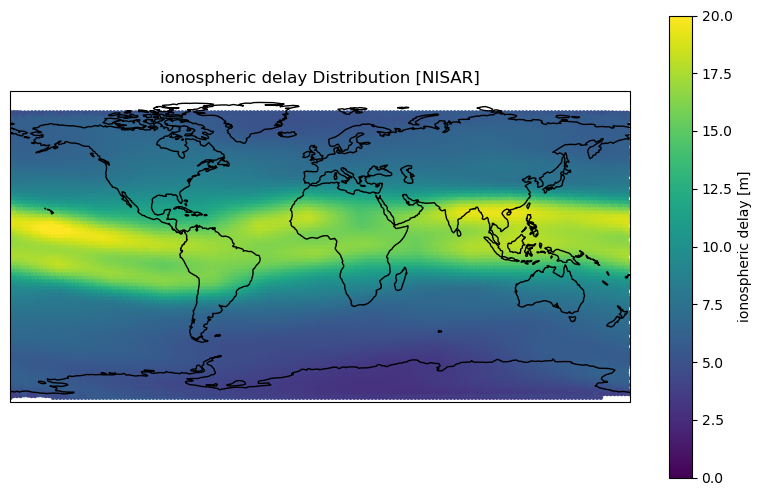

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 创建地图投影
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# 添加地形轮廓背景，仅画出黑色轮廓线
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# 绘制第一组数据
sc1 = ax.scatter(ascending_lon1, ascending_lat1, c=r_iono_means_1, cmap='viridis', s=6, alpha=1, transform=ccrs.PlateCarree(),vmin=0,vmax=20)
# 绘制第一组数据
sc2 = ax.scatter(ascending_lon2, ascending_lat2, c=r_iono_means_2, cmap='viridis', s=6, alpha=1, transform=ccrs.PlateCarree(),vmin=0,vmax=20)
# 绘制第一组数据
sc3 = ax.scatter(ascending_lon3, ascending_lat3, c=r_iono_means_3, cmap='viridis', s=6, alpha=1, transform=ccrs.PlateCarree(),vmin=0,vmax=20)
# 绘制第一组数据
sc4 = ax.scatter(ascending_lon4, ascending_lat4, c=r_iono_means_4, cmap='viridis', s=6, alpha=1, transform=ccrs.PlateCarree(),vmin=0,vmax=20)

# 设置横纵坐标范围
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# 创建一个共享的颜色条
cbar = plt.colorbar(sc1, label='ionospheric delay [m]')

plt.title('ionospheric delay Distribution [NISAR]')
plt.show()

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 假设每组数据长度相同
n = len(ascending_lon1)

# 计算坡度和坡向
dx = []
dy = []
center_lon = []
center_lat = []

for i in range(n):
    # 获取四个端点的经纬度和值
    lon1, lat1, z1 = ascending_lon1[i], ascending_lat1[i], r_iono_means_1[i]
    lon2, lat2, z2 = ascending_lon2[i], ascending_lat2[i], r_iono_means_2[i]
    lon3, lat3, z3 = ascending_lon3[i], ascending_lat3[i], r_iono_means_3[i]
    lon4, lat4, z4 = ascending_lon4[i], ascending_lat4[i], r_iono_means_4[i]

    # 计算中心点的经纬度
    center_loni = (lon1 + lon2 + lon3 + lon4) / 4
    center_lati = (lat1 + lat2 + lat3 + lat4) / 4

    # 计算坡度和坡向
    dz_dx = ((z2 - z1) + (z4 - z3)) / 2
    dz_dy = ((z3 - z2) + (z4 - z1)) / 2
    
    center_lon.append(center_loni)
    center_lat.append(center_lati)
    dx.append(dz_dx)
    dy.append(dz_dy)

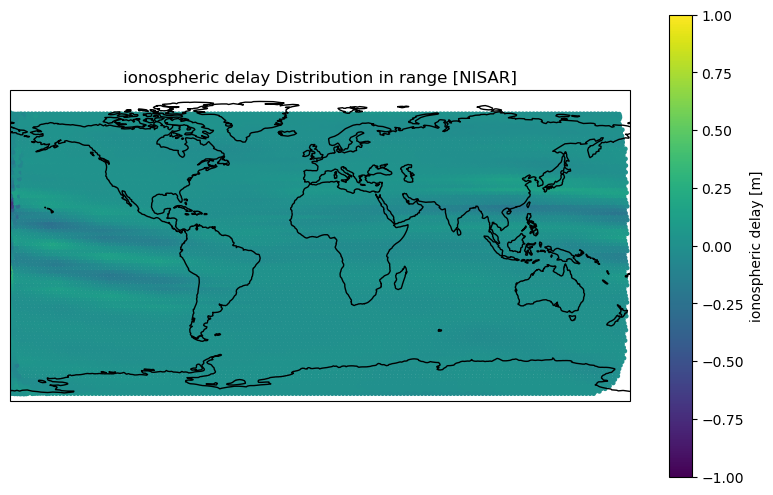

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 创建地图投影
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# 添加地形轮廓背景，仅画出黑色轮廓线
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# 绘制第一组数据
sc1 = ax.scatter(center_lon, center_lat, c=dx, cmap='viridis', s=6, alpha=1, transform=ccrs.PlateCarree(),vmin=-1,vmax=1)

# 设置横纵坐标范围
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# 创建一个共享的颜色条
cbar = plt.colorbar(sc1, label='ionospheric delay [m]')

plt.title('ionospheric delay Distribution in range [NISAR]')
plt.show()

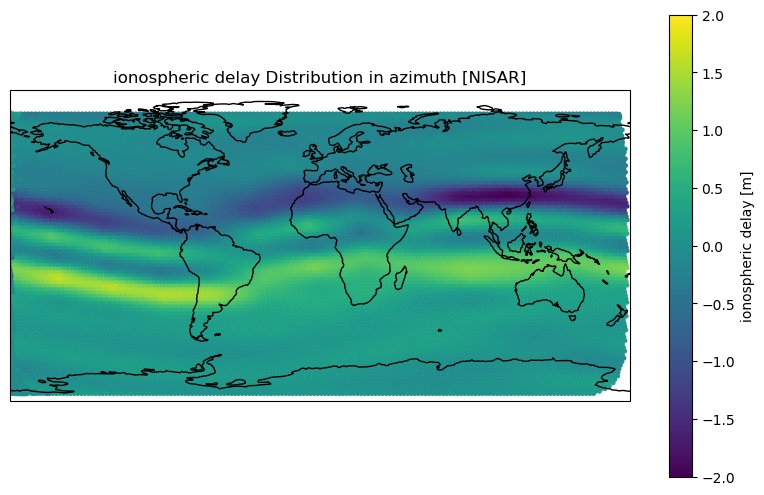

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 创建地图投影
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# 添加地形轮廓背景，仅画出黑色轮廓线
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# 绘制第一组数据
sc1 = ax.scatter(center_lon, center_lat, c=dy, cmap='viridis', s=6, alpha=1, transform=ccrs.PlateCarree(),vmin=-2,vmax=2)

# 设置横纵坐标范围
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# 创建一个共享的颜色条
cbar = plt.colorbar(sc1, label='ionospheric delay [m]')

plt.title('ionospheric delay Distribution in azimuth [NISAR]')
plt.show()